In [1]:
import numpy as np
from geometricus_deep_learning import utils, embedder
import matplotlib.pyplot as plt
import torch
from glob import glob
import pprint

%load_ext autoreload
%autoreload 2


In [2]:
import dataclasses

In [3]:
# First we define the type of moment invariants to be used in geometricus. Here I defined two, one is using 
# kmer splits and the other is using radius method to extract coordinates. Moment types for both include all
# implemented moment invariant types (16 of them)

invariant_types = [utils.InvariantType(type=embedder.SplitType.KMER, 
                                          k=30, moment_types=None),
                   utils.InvariantType(type=embedder.SplitType.KMER, 
                                          k=15, moment_types=None),
                   utils.InvariantType(type=embedder.SplitType.RADIUS, 
                                          k=10, moment_types=None)]

In [11]:
# grab the pdb files and use them as ids

pdb_ids = {x.split("/")[-1] for x in glob("data/smallset/*")}
len(pdb_ids)

2190

In [12]:
# Add labels if needed later (not used in training)

label_mapping = {k: "test" for k in pdb_ids}

In [14]:
# Create and train the model with InfoGraph. this takes some time..

emb = embedder.GeometricusGraphEmbedder.fit("./data/smallset/", invariant_types, label_mapping,
                                            epochs=50, file_output_path="./models/new/",
                                            learning_rate=0.001, number_of_batches=128,
                                            hidden_channels=50)

lr: 0.001
num_features: 48
hidden_dim: 50
num_gc_layers: 3
===== Before training =====
===== Epoch 1, Loss 21000.906177227313 =====
===== Epoch 2, Loss 7988.881246713491 =====
===== Epoch 3, Loss 4862.017106276292 =====
===== Epoch 4, Loss 4410.574678861178 =====
===== Epoch 5, Loss 3462.007071861854 =====
===== Epoch 6, Loss 2647.5541575505185 =====
===== Epoch 7, Loss 2199.761689406175 =====
===== Epoch 8, Loss 1903.488017155574 =====
===== Epoch 9, Loss 1947.8707463191106 =====
===== Epoch 10, Loss 1696.7046356201172 =====
===== Epoch 11, Loss 1329.2842495258037 =====
===== Epoch 12, Loss 1178.0158268855168 =====
===== Epoch 13, Loss 1054.1741723280686 =====
===== Epoch 14, Loss 1249.4710713900054 =====
===== Epoch 15, Loss 1106.7674457843486 =====
===== Epoch 16, Loss 1029.0492480351375 =====
===== Epoch 17, Loss 898.9744124779335 =====
===== Epoch 18, Loss 840.0899015573355 =====
===== Epoch 19, Loss 781.915044931265 =====
===== Epoch 20, Loss 709.5183668870193 =====
===== Epoch 2

In [17]:
emb = embedder.GeometricusGraphEmbedder.from_model_meta_file("./models/new/meta.pkl")

In [18]:
torch.cuda.empty_cache() # this forces garbage collection

In [19]:
# Some info on the embedding class

dataclasses.asdict(emb.model_meta)

{'model_path': 'models/new/model.pth',
 'pdb_folder': 'data/smallset',
 'self_path': 'models/new/meta.pkl',
 'id_to_classname_path': 'models/new/class_map.pkl',
 'invariant_types': [{'type': <SplitType.KMER: 1>,
   'k': 30,
   'moment_types': None},
  {'type': <SplitType.KMER: 1>, 'k': 15, 'moment_types': None},
  {'type': <SplitType.RADIUS: 2>, 'k': 10, 'moment_types': None}],
 'original_invariants_file': 'models/new/invariants.pkl',
 'dataset_path': 'models/new/train_set.pkl'}

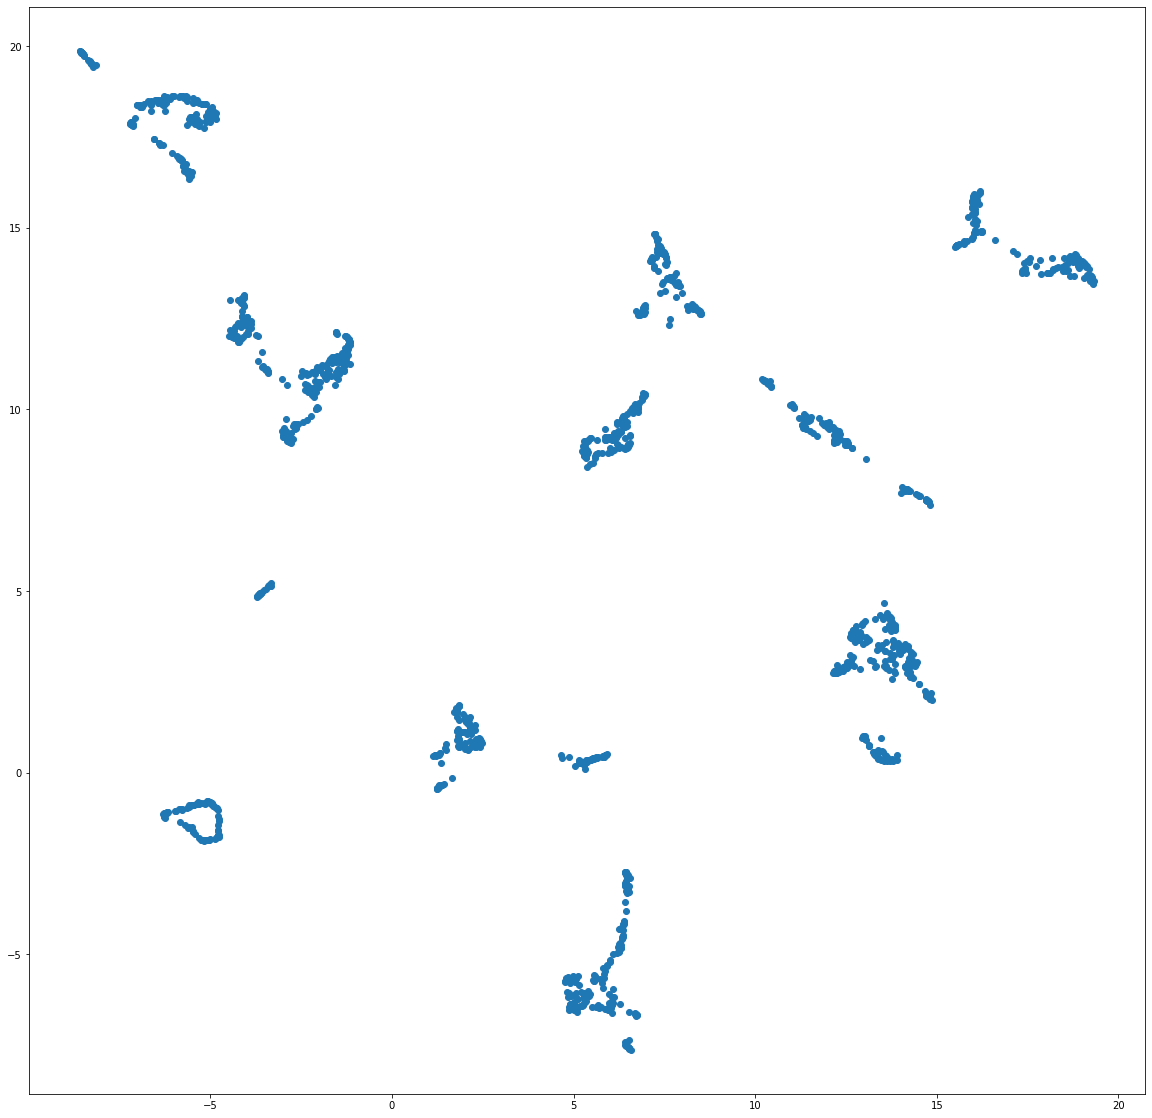

In [20]:
# Here use dimentionality reduction using umap to visualize some clusters

from umap import UMAP

umap_embedding = UMAP().fit_transform(emb.get_self_embedding()[0])

plt.figure(figsize=(20,20))
plt.scatter(
    umap_embedding[:, 0],
    umap_embedding[:, 1])
plt.gca().set_aspect('equal', 'datalim')